<img src="../../Img/backdrop-wh.png" alt="Drawing" style="width: 300px;"/>  

# GPT-2

* * * 

<div class="alert alert-success">  
    
### Learning Objectives 
    
* Understand GPT-2 as a large language model.
* Reviewing output from pretrained GPT-2 model using the `transformers` library.
* Understand the hyperparameters for GPT-2's output generation.
* Learn how to finetune GPT-2 on AITA data using a truncation and sliding windows approach.
* Evaluate differently finetuned GPT-2 models through perplexity scores and manual interpretation.

</div>

### Icons Used in This Notebook
🔔 **Question**: A quick question to help you understand what's going on.<br>
⚠️ **Warning:** Heads-up about tricky stuff or common mistakes.<br>

### Sections
1. [What is GPT-2?](#gpt2)
2. [Finetuning GPT-2](#ft)
3. [Evaluation: Perplexity](#perp)
4. [Evaluation: Interpretation](#int)

<a id='gpt2'></a>
# What is GPT-2?

"GPT" Stands for Generative Pre-trained Transformer. *Generative*, because it generates text. Pre-trained, because it has been trained on a massive amount of data, and "pre" insinuates one could further train, or **finetune**, this model. A *transformer* is a specific kind of neural network. You can build different models from transformer architecture; the training goal of GPT is to take in a piece of text, and produce a prediction of what comes next in the passage.

GPT-2 is the model from 2019. It was trained on a dataset of 8 million web pages. In this notebook, we are using GPT-2 Small, the base model, which has only (!) 117 million parameters (for comparison, GPT-2 XL has 1.5 billion parameters, and GPT4 has 175 *billion*). A "parameter" is an adjustable internal value that the model learns and uses to make predictions or generate text based on its input. More parameters usually means a "smarter", more capable model.

We use this smaller model to make it possible to finetune it on a local computer (although you still need a pretty recent machine to run the code in this notebook). 

## What is fine-tuning?
Fine-tuning GPT-2 on a specific dataset, like our r/amitheasshole dataset, customizes the model's responses to reflect the themes, style, language, or idioms found within that corpus. This process tailors the model's generative capabilities, making it more likely to produce outputs that are stylistically and thematically aligned with the fine-tuning material.

The model's adaptation will be more pronounced when generating text related to or prompted by the domain we train it on. This might include specific narrative styles, dialogue structures, and  conventions unique to Am I The Asshole.

## Weight Adjustment
Fine-tuning adjusts the weights of the neural network to minimize the loss on the new data. The changes in weights help the model better predict or generate sequences that resemble the fine-tuning data.

## Importing packages

⚠️ **Warning:** I recommend running this code in a new environment. Read more [here](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html) if you want to know how this works. The PyTorch and Transformers packages require very specific versions that might clash with other installed packages.

After importing, check which versions of the packages we have.

In [ ]:
# Uncomment the following to install PyTorch and Transformers libraries

#%pip install torch
#%pip install transformers

In [4]:
import torch
import transformers
print(torch.__version__)
print(transformers.__version__)

2.1.1
4.35.2


Let's generate some text. We will use DistilGPT2 (short for Distilled-GPT2), a model pre-trained with the supervision of the smallest version of Generative Pre-trained Transformer 2 (GPT-2). 

Our input text will be a typical title from an r/aita post. By looking at how the model completes this sentence, we get a sense of its internal logic, and whether it "understands" what an r/aita post looks like.

In [5]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Set the seed for PyTorch (controls randomness for reproducibility)
seed = 1
torch.manual_seed(seed)

# Load pretrained model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('distilgpt2')

# Encode input context to get token IDs
input_text = "AITA for pretending to get fired when customers get a temper with me?"
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# Generate text using the model
output = model.generate(input_ids, 
                        do_sample=True, 
                        max_length=150, 
                        repetition_penalty=1.1,
                        temperature=1, 
                        top_k=50, 
                        top_p=0.95
                        )

# Decode the generated IDs to text
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print(generated_text)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


AITA for pretending to get fired when customers get a temper with me? You don't really have the energy and talent they need.
The people that do not exist are those who will always be there in order for their jobs and lives to come true, but at this point most of them want someone else's job instead.


🔔 **Question**: Does this output make sense? 

### On Predicting Text

What is happening here? The model tokenizes our `input_text` into subwords (or tokens), and then maps each token onto an embedding vector (i.e., a long list of numbers), which it has learned during training. The model then uses these embeddings to predict the most-likely words to appear after our input text ends. It then draws on probability distribution to generate text, word by word.

A few things to note about the arguments we pass into `model.generate`:

- When `do_sample=True`, the model generates text by **sampling** from the probability distribution of the next token given the context. This distribution is determined by the model's predictions. Instead of simply picking the most probable next token (deterministic), the model randomly selects the next token based on this probability distribution, which can introduce variety and creativity in the generated text.
- `max_length` tells the model how many tokens its response should be.
- `repetition_penalty`
- Parameters like `temperature`, `top_k`, and `top_p` modify this distribution to control diversity and coherence of the output:
    - `temperature`: Controls the randomness of the generated output. Higher temperature makes the output distribution more uniform, so you are likely to get more diverse generations
    - `top-p`: Samples tokens with the highest probability scores until the sum of the scores reaches the specified threshold value. 
    - `top-k`: Samples tokens with the highest probabilities until the specified number of tokens is reached.
 


### Visualizing Embeddings 

As we have seen last week, visualizing the embedding space of a model can provide valuable insights into the structure and potential biases of the learned representations. 

Let's do this for the `distilgpt2` model using principal component analysis (PCA).

In [6]:
model = GPT2LMHeadModel.from_pretrained('distilgpt2')
embeddings = model.transformer.wte.weight.detach().numpy()

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
words = ["mother", "father", "wife", "husband", "sibling", "friend", "asshole", "selfish", "dishonest", "belittles", "dismissive", "inconsiderate", "overreacts"]
word_indices = [tokenizer.encode(word)[0] for word in words]
selected_embeddings = embeddings[word_indices]

In [81]:
selected_embeddings

array([[-0.08683544, -0.0742779 ,  0.08279706, ...,  0.1882141 ,
         0.08212308, -0.00772696],
       [-0.04411615, -0.2743945 ,  0.09602286, ...,  0.1457259 ,
         0.1467388 , -0.01477893],
       [ 0.02956365, -0.10193486,  0.04898852, ..., -0.08164124,
         0.27095503, -0.17627896],
       ...,
       [ 0.09597927, -0.07860076,  0.2188769 , ...,  0.27255607,
         0.14034851, -0.02970902],
       [-0.01643876, -0.17959502,  0.17055063, ...,  0.0508506 ,
         0.04920006, -0.05104805],
       [-0.07287488, -0.13610548,  0.06346617, ...,  0.15324672,
        -0.18826947,  0.02226485]], dtype=float32)

In [82]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Using PCA
pca = PCA(n_components=2)
reduced_embeddings_pca = pca.fit_transform(selected_embeddings)

In [83]:
# Uncomment the following line to install adjustText 

#%pip install adjustText

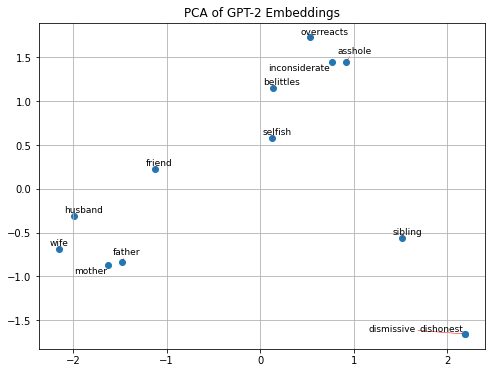

In [84]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Function to plot
def plot_embeddings(embeddings, labels, title='PCA of GPT-2 Embeddings'):
    plt.figure(figsize=(8, 6))
    texts = []
    points = plt.scatter(embeddings[:, 0], embeddings[:, 1])  # scatter plot of embeddings

    # Generate text annotations
    for i, label in enumerate(labels):
        x, y = embeddings[i]
        text = plt.text(x, y, label, ha='right', va='bottom', fontsize=9)
        texts.append(text)

    # Use adjust_text to avoid overlapping
    adjust_text(texts, x=embeddings[:, 0], y=embeddings[:, 1], arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

    plt.title(title)
    plt.grid(True)
    plt.show()

# Example usage (assuming 'reduced_embeddings_pca' and 'words' are defined)
plot_embeddings(reduced_embeddings_pca, words, title='PCA of GPT-2 Embeddings')


<a id="ft"></a>

# Finetuning GPT-2 - OPTIONAL

### ⚠️ Warning
Even though we are only training a small model, the following blocks of code operation will take long on a consumer-grade PC (for reference: around 4 hours on an Apple M2 Pro with 16GB memory). I have run this code and saved the model, so you don't have to run it yourself. Please move on to "Getting the Model From Google Drive". 

If you do choose to run the model yourself, you may want to run this notebook in Google Colab using a GPU. See Modules in bCourses for the link.


## Tokenizing our Data

Time to start the finetuning process. We first load in our r/aita dataset and initialize a tokenizer.

The tokenizer performs several critical tasks to convert raw text into a format that the GPT-2 model can understand:

- Splitting Text into Tokens: The tokenizer breaks down input text into tokens. For GPT-2, these tokens are usually subwords or characters, allowing the model to handle a wide range of words and vocabularies efficiently.
- Converting Tokens to IDs: Each token is mapped to a unique integer ID based on the GPT-2 vocabulary. This conversion is necessary because neural networks operate on numerical data, not raw text.
- Adding Special Tokens: GPT-2 requires certain special tokens for its operation (e.g., end-of-text token). The tokenizer takes care of adding these tokens where appropriate.
- Padding & Truncation: To process batches of data efficiently, all input sequences must be of the same length. The tokenizer can pad shorter sequences with a special padding token or truncate longer ones to a maximum length.
- Creating Attention Masks: The tokenizer generates attention masks to differentiate real tokens from padding tokens. This helps the model pay attention to relevant tokens and ignore padded areas.

In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv('../../data/aita_pp.csv')

In [8]:
texts = df['selftext'].tolist()

## Commence Tokenization

We will tokenize the entire texts with truncation and padding to a fixed maximum length. This method is straightforward and treats each text as an individual sequence for the model to learn from. The main characteristics include:

- `truncation`: Texts longer than `max_length=512` are cut off, potentially losing important information at the end.
- `padding`: Texts shorter than `max_length=512` are padded to ensure uniform sequence length, usually with the pad_token. This is not relevant to us as all texts we are feeding into the model are much longer than 512 tokens.

During fine-tuning, the prediction task involves predicting the next token in the sequence based on the preceding tokens. So, for each input sequence (i.e., for each Irish drama text) consisting of its first 512 tokens, the model  predicts the next token for each token position within that sequence. The model predicts tokens from the second to the 512th position within each sequence. 

In [9]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments

# Initialize tokenizer with padding token set
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
tokenizer.pad_token = tokenizer.eos_token

# Tokenize texts
encodings = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

In [10]:
import torch
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    
    def __len__(self):
        return len(self.encodings.input_ids)
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # For language modeling, the labels are the input_ids shifted by one
        item["labels"] = item["input_ids"].clone()
        return item

# Initialize the dataset
train_dataset = TextDataset(encodings)

## Commence Finetuning

In the following cell, we initialize the fine-tuning process using Hugging Face's `Trainer` class.

The first parameter, `model`, is the pre-trained distilGPT-2 model that we intend to fine-tune. It has been previously loaded and is now set to be further trained on our specific dataset to adjust its weights based on the new data, enhancing its ability to generate or understand text similar to your training corpus.

`TrainingArguments` further specifies various configuration settings for the training process:
- `output_dir`: The directory where the training outputs (like the fine-tuned model checkpoints) will be saved.
- `num_train_epochs`: The number of times the training process should iterate over the entire dataset. Here, it's set to 3, meaning the model will see the dataset three times.
- `per_device_train_batch_size`: The number of training examples processed per device (e.g., GPU) per training step. A batch size of 4 is specified, balancing the computational load and memory usage.
- `logging_dir`: Directory where training logs will be saved, enabling monitoring of the training process through metrics like loss over time.

Finally, `trainer.train()` starts the training process based on the specified model, training arguments, and dataset. The Trainer handles various training aspects, including feeding the input data to the model, performing backpropagation to adjust the model's weights, saving checkpoints, and logging training progress.

⚠️ **Warning:** Even though we are using a small model, the following operation will take *long* on a consumer-grade PC (for reference: around 4 hours on an Apple M2 Pro with 16GB memory).
I have run this code and saved the model, so you don't have to run it yourself. If you choose to do so, be patient!

In [ ]:
# Initialize the model
model = GPT2LMHeadModel.from_pretrained('distilgpt2')

# Define training arguments
training_args = TrainingArguments(
    output_dir='../../results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    logging_dir='../../logs'
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

# Start training
trainer.train()

If you did run the previous code, make sure to save the model and finetuned tokenizer:

In [26]:
model_save_path = '../../models/finetuned_model'
tokenizer_save_path = '../../models/finetuned_tokenizer'

# Save the model
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_save_path)


('../../models/finetuned_tokenizer/tokenizer_config.json',
 '../../models/finetuned_tokenizer/special_tokens_map.json',
 '../../models/finetuned_tokenizer/vocab.json',
 '../../models/finetuned_tokenizer/merges.txt',
 '../../models/finetuned_tokenizer/added_tokens.json')

## Getting the Model From Google Drive

To save us time, I saved the model we created on Google Drive. A link to the folder you need to download is in bCourses under Modules (look for "Finetuned GPT2 Model on Google Drive"). 

Download the "models" folder and put it in your local "DIGHUM160-main" repo. The result should be that you have the "models" folder inside your "DIGHUM160-main" folder, like so:

<img src="../../img/ex.png" alt="Making sure 'models' and 'tokenizer' folders are present in DIGHUM160 folder" width="500"/>


<a id="int"></a>
# Interpreting Model Output

Let's have a look at the ways DistilGPT2's behavior has been altered due to the finetuning on r/aita.

In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Set the seed for PyTorch (controls randomness for reproducibility)
seed = 1
torch.manual_seed(seed)

def generate_text(model, prompt, do_sample=True, max_length=50, temperature=1, top_k=50, top_p=0.95, repetition_penalty=1.1):
    """
    Generates text based on a given prompt using the specified model.
    
    Parameters:
    - model: The fine-tuned model to use for text generation.
    - prompt: The initial text to start generating from.
    - max_length: Maximum length of the generated text.
    - temperature: Sampling temperature for generating text.
    - top_k: The number of highest probability vocabulary tokens to keep for top-k filtering.
    - top_p: Nucleus sampling's cumulative probability cutoff to keep for top-p filtering.
    
    Returns:
    - generated_text: The generated text as a string.
    """
    # Encode the prompt text to tensor
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    
    # Generate a sequence of tokens following the prompt
    output_ids = model.generate(input_ids, max_length=max_length, 
                                temperature=temperature, 
                                do_sample=do_sample, 
                                top_k=top_k, 
                                top_p=top_p, 
                                repetition_penalty=repetition_penalty, 
                                pad_token_id=tokenizer.eos_token_id)
    
    # Decode the generated tokens to a string
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    return generated_text

# Load the fine-tuned model
ft_model = GPT2LMHeadModel.from_pretrained('../../models/finetuned_model')

# Load the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('../../models/finetuned_tokenizer')

# Prompt to generate text from - play around with this!
prompt = "AITA for pretending to get fired when customers get a temper with me?"

# Generate texts
generated_text = generate_text(ft_model, prompt, max_length=150)
print("Generated text from finetuned model:", generated_text, '\n')


Generated text from finetuned model: AITA for pretending to get fired when customers get a temper with me?
I (29M) have this friend group “Tim” who is an all-time high school teacher. I've always gotten into arguments and the fact that he doesn't give in gets us some bad karma, especially since it really upsets him because of how easily he makes himself look weak by telling his classmates or taking on their own time away from them so why are we going against each other like there's more fun between you guys?! He hates everything but if someone tells your students shit about something they're making sure no one else has said enough stuff before then try asking friends out too... Well my coworker wants her to go ahead and sign 



## Visualizing Finetuned Embeddings

In [85]:
ft_model = GPT2LMHeadModel.from_pretrained('../../models/finetuned_model')
embeddings = ft_model.transformer.wte.weight.detach().numpy()

tokenizer = GPT2Tokenizer.from_pretrained('../../models/finetuned_tokenizer')
words = ["mother", "father", "wife", "husband", "sibling", "friend", "asshole", "selfish", "dishonest", "belittles", "dismissive", "inconsiderate", "overreacts"]
word_indices = [tokenizer.encode(word)[0] for word in words]
selected_embeddings = embeddings[word_indices]

In [86]:
selected_embeddings

array([[-0.08983608, -0.07566703,  0.08349369, ...,  0.18283577,
         0.07841988, -0.01275523],
       [-0.05157953, -0.26721314,  0.09504529, ...,  0.1388949 ,
         0.14095911, -0.01402224],
       [ 0.02989762, -0.09685647,  0.04845227, ..., -0.08580636,
         0.26195088, -0.16775285],
       ...,
       [ 0.08400729, -0.0799709 ,  0.22428474, ...,  0.26498145,
         0.13029073, -0.04067934],
       [-0.01342215, -0.18512474,  0.18063144, ...,  0.04760199,
         0.05262458, -0.0501127 ],
       [-0.07873819, -0.13558358,  0.06410827, ...,  0.14596112,
        -0.1911063 ,  0.02714493]], dtype=float32)

In [87]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Using PCA
pca = PCA(n_components=2)
reduced_embeddings_pca = pca.fit_transform(selected_embeddings)

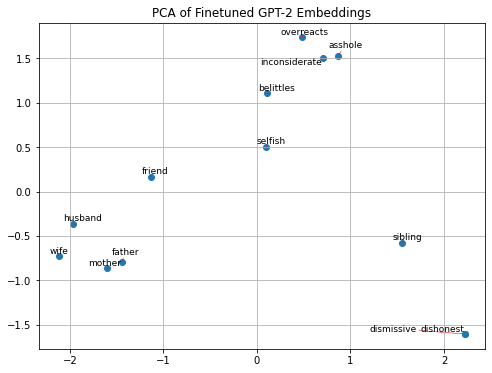

In [88]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Function to plot
def plot_embeddings(embeddings, labels, title='PCA of GPT-2 Embeddings'):
    plt.figure(figsize=(8, 6))
    texts = []
    points = plt.scatter(embeddings[:, 0], embeddings[:, 1])  # scatter plot of embeddings

    # Generate text annotations
    for i, label in enumerate(labels):
        x, y = embeddings[i]
        text = plt.text(x, y, label, ha='right', va='bottom', fontsize=9)
        texts.append(text)

    # Use adjust_text to avoid overlapping
    adjust_text(texts, x=embeddings[:, 0], y=embeddings[:, 1], arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

    plt.title(title)
    plt.grid(True)
    plt.show()

# Example usage (assuming 'reduced_embeddings_pca' and 'words' are defined)
plot_embeddings(reduced_embeddings_pca, words, title='PCA of Finetuned GPT-2 Embeddings')


# Create Posts Using Finetuned Model

What can we do with this finetuned model? Well, for one, we could generate Am I The Asshole posts!

We will as kthe model to generate text based on the title of the original post. We will also ask it to create a post that is the same length as the original post.

In [77]:
import pandas as pd
import random
from transformers import GPT2Tokenizer, GPT2LMHeadModel, pipeline

# Load your data
df = pd.read_csv('../../data/aita_pp.csv')

# Randomly select 10 entries
sample_df = df.sample(n=10, random_state=1)  # Use a fixed seed for reproducibility, if needed

original_texts = sample_df['selftext'].tolist()  # Adjust column name if different
titles = sample_df['title'].tolist()

# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('../../models/finetuned_tokenizer')
model = GPT2LMHeadModel.from_pretrained('../../models/finetuned_model')

# Initialize the generation pipeline
generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=-1)  # CPU usage

# Prepare to generate texts
generated_texts = []
for title, original_text in zip(titles, original_texts):
    # Calculate the length of the original post in tokens
    target_length = len(tokenizer.encode(original_text))

    # Generate a new post of the same length starting from the title
    # Ensure to set max_length to the length of the original post
    prompt = title
    generated = generator(prompt, max_length=target_length, num_return_sequences=1)[0]['generated_text']
    generated_texts.append(generated)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Let's save the original and generated posts in a new DataFrame so we can easily compare them.

In [78]:
df = pd.DataFrame({
    'original_text': original_texts,
    'generated_text': generated_texts,
    'title': titles  # Assuming you have a list of titles
})

Let's compare original posts to the ones we created with GPT-2. Here we are selecting an index from our new DataFrame and printing the text for both the original and our generated text.

**🔔 Question:** What do you make of this specific generated post? Can you tell why the model seems to have created the output that it did?

In [89]:
index = 2
print(f"Title: {df.loc[index]['title']}")
print("\n")
print(f"Original Text: {df.loc[index, 'original_text']}")
print("\n")
print(f"Generated Text: {df.loc[index, 'generated_text']}")

Title: AITA for not wanting to pay for brother's life-saving surgery?


Original Text: My brother was recently diagnosed with late stage colon cancer and has been in hospital multiple times to get assessments and diagnostic testing. The definitive treatment is a surgery and lengthy hospital stay which costs about $25k out-of-pocket after insurance deductions, and quoted at 70% cure rate. He and my SIL are unable to afford this as they have combined debts of $40k including student loans and not eligible to take more credit. They can at most put together $5000 in time to have the surgery soon enough that it's still effective.

They came to me asking for a loan of $20k. This is my brother here, and they have a 4-year-old daughter and I wouldn't wish for anyone to see their dad die. But $20k is not something we can readily hand out. Debt can destroy lives, and if my wife and I have a mortgage to pay off. If we are out $20k (which will probably get turned into a gift because that's just how

In [ ]:
# %pip install TextBlob

In [81]:
from textblob import TextBlob

def compare_posts(index):
    if index < 0 or index >= len(df):
        print("Invalid index, please choose a valid post index.")
        return
    
    # Display the texts
    print(f"Title: {df.loc[index, 'title']}")

    # Sentiment analysis
    original_blob = TextBlob(df.loc[index, 'original_text'])
    generated_blob = TextBlob(df.loc[index, 'generated_text'])
    print("\nSentiment Analysis:")
    print(f"Original Sentiment: Polarity = {original_blob.sentiment.polarity}, Subjectivity = {original_blob.sentiment.subjectivity}")
    print(f"Generated Sentiment: Polarity = {generated_blob.sentiment.polarity}, Subjectivity = {generated_blob.sentiment.subjectivity}")
    
# Example usage: compare post at index 5
compare_posts(5)


Title: AITA for telling my BF that if he doesnt go to work, hes no longer using ANYTHING of mine (including my car AND wifi)?

Sentiment Analysis:
Original Sentiment: Polarity = -0.12668650793650793, Subjectivity = 0.4997685185185186
Generated Sentiment: Polarity = -0.02837941628264208, Subjectivity = 0.5461597542242704


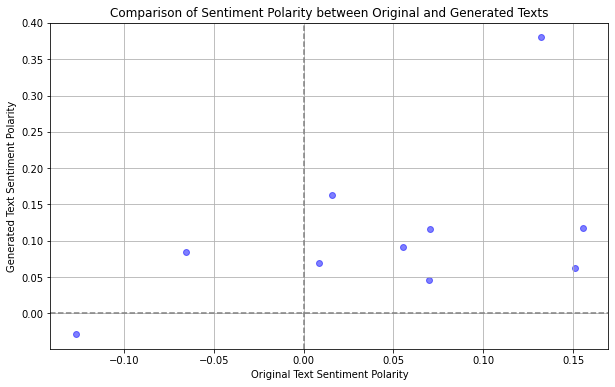

In [82]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

# Define a function to calculate sentiment polarity
def get_sentiment_polarity(texts):
    return [TextBlob(text).sentiment.polarity for text in texts]

# Calculate sentiment polarity for both original and generated texts
df['original_polarity'] = get_sentiment_polarity(df['original_text'])
df['generated_polarity'] = get_sentiment_polarity(df['generated_text'])

plt.figure(figsize=(10, 6))
plt.scatter(df['original_polarity'], df['generated_polarity'], alpha=0.5, color='blue')
plt.title('Comparison of Sentiment Polarity between Original and Generated Texts')
plt.xlabel('Original Text Sentiment Polarity')
plt.ylabel('Generated Text Sentiment Polarity')
plt.grid(True)
plt.axhline(y=0, color='gray', linestyle='--')
plt.axvline(x=0, color='gray', linestyle='--')
plt.show()


## Back to TF-IDF

We can use the TF-IDF algorithm to check the similarity between original texts and the ones we generated!

In [83]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Combine original and generated texts into one list for TF-IDF analysis
texts = df['original_text'].tolist() + df['generated_text'].tolist()

# Initialize a TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the data
tfidf_matrix = vectorizer.fit_transform(texts)

# Calculate cosine similarity between original and generated texts
# Assuming the first half are originals and the second half are generated
similarity_matrix = cosine_similarity(tfidf_matrix[:len(df)], tfidf_matrix[len(df):])

# Display similarity results
for i, similarity in enumerate(similarity_matrix.diagonal()):
    print(f"Text {i+1} Similarity between original and generated: {similarity:.4f}")


Text 1 Similarity between original and generated: 0.3928
Text 2 Similarity between original and generated: 0.3931
Text 3 Similarity between original and generated: 0.3107
Text 4 Similarity between original and generated: 0.2668
Text 5 Similarity between original and generated: 0.4319
Text 6 Similarity between original and generated: 0.4193
Text 7 Similarity between original and generated: 0.3908
Text 8 Similarity between original and generated: 0.4231
Text 9 Similarity between original and generated: 0.2293
Text 10 Similarity between original and generated: 0.3204


These results, with values primarily between 0.3 and 0.5, suggest that the generated texts share some vocabulary and thematic elements with the original texts but also diverge in significant ways.

## Back to Word Embeddings

Finally, let's project the reduced embeddings for both the original and our generated posts in 2D space.

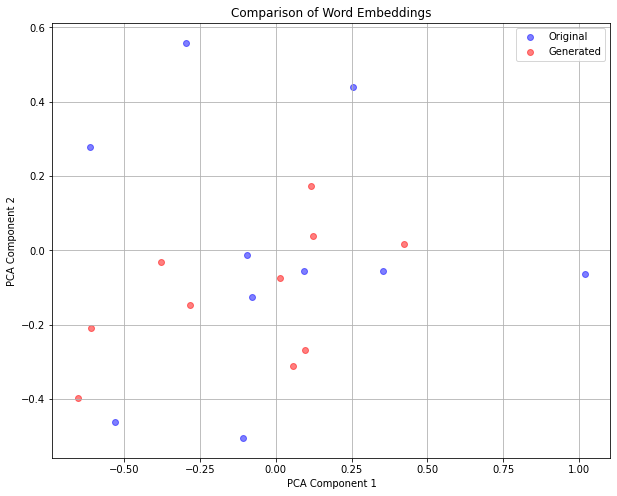

In [84]:
import spacy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the medium model with word vectors
nlp = spacy.load("en_core_web_sm")

# Sample data (assuming df is already loaded)
original_texts = df['original_text'].tolist()[:10]  # Limiting for simplicity
generated_texts = df['generated_text'].tolist()[:10]

# Function to compute average embeddings for a text
def get_average_embedding(text, nlp_model):
    doc = nlp_model(text)
    vectors = [word.vector for word in doc if not word.is_stop and word.has_vector]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros((nlp_model.vocab.vectors_length,))

# Compute average embeddings for each set of texts
original_embeddings = np.array([get_average_embedding(text, nlp) for text in original_texts])
generated_embeddings = np.array([get_average_embedding(text, nlp) for text in generated_texts])

# Perform PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
original_pca = pca.fit_transform(original_embeddings)
generated_pca = pca.transform(generated_embeddings)

# Plotting the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(original_pca[:, 0], original_pca[:, 1], color='blue', label='Original', alpha=0.5)
plt.scatter(generated_pca[:, 0], generated_pca[:, 1], color='red', label='Generated', alpha=0.5)
plt.title('Comparison of Word Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()


# 💭 Reflection: The hermeneutics of Large Language Models

I encourage you to think about the interpretative dimensions of Large Language Models. Trained on reams of texts, they produce text based on statistically backed prediction. In a way, they are themselves based on a certain "model": one that interprets reality as the statistical average. 

How can we think about these models in terms of the hermeneutic concepts we have been discussing? 

<div class="alert alert-success">

## ❗ Key Points

* The GPT model is trained to take in a piece of text, and produce a prediction of what comes next in the passage.
* Fine-tuning GPT-2 on a specific dataset, like our r/amitheasshole dataset, customizes the model's responses to reflect the themes, style, language, or idioms found within that corpus.
* We can evaluate a fine-tuned model with different metrics, and through manual interpretation. 
    
</div>